In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir data
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/extracted_features.npy"
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/labels.npy"
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/features_stretched.npy"
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/labels_stretched.npy"
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/features_pitch_shifted.npy"
!cd data && wget "http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/labels_pitch_shifted.npy"

--2020-12-23 11:00:45--  http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/extracted_features.npy
Connecting to 164.68.116.174:5000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126886528 (121M) [application/octet-stream]
Saving to: ‘extracted_features.npy’

extracted_features. 100%[===================>] 121.01M  22.8MB/s    in 6.0s    

2020-12-23 11:00:52 (20.1 MB/s) - ‘extracted_features.npy’ saved [126886528/126886528]

--2020-12-23 11:00:52--  http://164.68.116.174:5000/download/files/isep/a3/deep-learning/respiratory-sound/labels.npy
Connecting to 164.68.116.174:5000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51648 (50K) [application/octet-stream]
Saving to: ‘labels.npy’

labels.npy          100%[===================>]  50.44K   263KB/s    in 0.2s    

2020-12-23 11:00:52 (263 KB/s) - ‘labels.npy’ saved [51648/51648]

--2020-12-23 11:00:52--  http://164.68.116.174:5000/download/files/isep/a3/deep-lear

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
origin_features, origin_labels = np.load('/content/data/extracted_features.npy'), np.load('/content/data/labels.npy')
origin_features = np.delete(origin_features, np.where((origin_labels == 'Asthma') | (origin_labels == 'LRTI'))[0], axis=0)
origin_labels = np.delete(origin_labels, np.where((origin_labels == 'Asthma') | (origin_labels == 'LRTI'))[0], axis=0)

In [6]:
features_stretched, labels_stretched = np.load('/content/data/features_stretched.npy'), np.load('/content/data/labels_stretched.npy')
features_stretched = np.delete(features_stretched, np.where((labels_stretched == 'Asthma') | (labels_stretched == 'LRTI'))[0], axis=0)
labels_stretched = np.delete(labels_stretched, np.where((labels_stretched == 'Asthma') | (labels_stretched == 'LRTI'))[0], axis=0)

In [7]:
features_pitch_shifted, labels_pitch_shifted = np.load('/content/data/features_pitch_shifted.npy'), np.load('/content/data/labels_pitch_shifted.npy')
features_pitch_shifted = np.delete(features_pitch_shifted, np.where((labels_pitch_shifted == 'Asthma') | (labels_pitch_shifted == 'LRTI'))[0], axis=0)
labels_pitch_shifted = np.delete(labels_pitch_shifted, np.where((labels_pitch_shifted == 'Asthma') | (labels_pitch_shifted == 'LRTI'))[0], axis=0)

In [8]:
features = np.concatenate((origin_features, features_stretched), axis=0)
features = np.concatenate((features, features_pitch_shifted), axis=0)
labels = np.concatenate((origin_labels,labels_stretched), axis=0)
labels = np.concatenate((labels,labels_pitch_shifted), axis=0)
classes = ['COPD', 'Pneumonia', 'Healthy', 'URTI', 'Bronchiectasis', 'Bronchiolitis']

In [9]:
le = LabelEncoder()
i_labels = le.fit_transform(labels)
oh_labels = to_categorical(i_labels)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, oh_labels, stratify=oh_labels, test_size=0.2, random_state=42)
num_rows, num_columns, num_channels = 40, 862, 1  # input shape

In [11]:
num_labels = oh_labels.shape[1]
filter_size = 2

In [12]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

In [13]:
num_epochs = 250
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]

In [14]:
model.fit(np.expand_dims(x_train, axis=3), y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(np.expand_dims(x_test, axis=3), y_test), callbacks=callbacks, verbose=1)

Epoch 1/250
31/31 [==============================] - 10s 56ms/step - loss: 6.8929 - accuracy: 0.2537 - val_loss: 1.6438 - val_accuracy: 0.3222

Epoch 00001: val_accuracy improved from -inf to 0.32225, saving model to mymodel2_01.h5
Epoch 2/250
31/31 [==============================] - 1s 36ms/step - loss: 1.5841 - accuracy: 0.4155 - val_loss: 1.4170 - val_accuracy: 0.5010

Epoch 00002: val_accuracy improved from 0.32225 to 0.50104, saving model to mymodel2_02.h5
Epoch 3/250
31/31 [==============================] - 1s 35ms/step - loss: 1.2881 - accuracy: 0.5050 - val_loss: 1.3329 - val_accuracy: 0.4927

Epoch 00003: val_accuracy did not improve from 0.50104
Epoch 4/250
31/31 [==============================] - 1s 35ms/step - loss: 1.2057 - accuracy: 0.5408 - val_loss: 1.3240 - val_accuracy: 0.4678

Epoch 00004: val_accuracy did not improve from 0.50104
Epoch 5/250
31/31 [==============================] - 1s 35ms/step - loss: 1.1042 - accuracy: 0.5753 - val_loss: 1.3317 - val_accuracy: 0.4

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


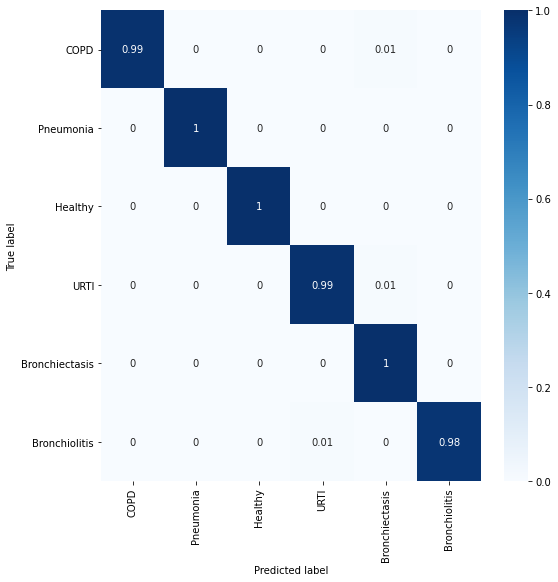

In [15]:
y_pred=model.predict_classes(np.expand_dims(x_train, axis=3))
rounded_labels=np.argmax(y_train, axis=1)
con_mat = confusion_matrix(rounded_labels, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


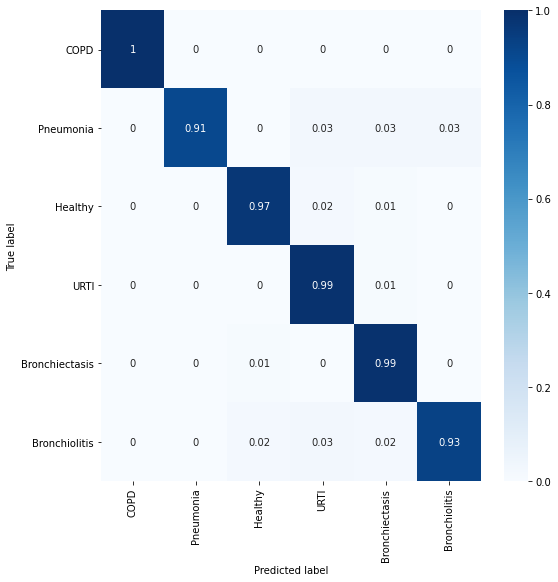

In [16]:
y_pred=model.predict_classes(np.expand_dims(x_test, axis=3))
rounded_labels=np.argmax(y_test, axis=1)
con_mat = confusion_matrix(rounded_labels, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
model.save('/content/drive/My Drive/ISEP/A3/DEEP LEARNING/Respiration Sound/model_with stretched_data.h5', save_format='h5')

In [ ]:
model = load_model('/content/drive/My Drive/ISEP/A3/DEEP LEARNING/Respiration Sound/model.h5')